# Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


# 读取Mnist数据集
- 会自动进行下载

In [63]:
%matplotlib inline

In [64]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [65]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


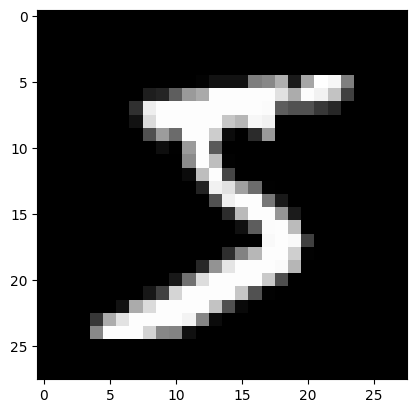

In [66]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

## 注意数据需转换成tensor才能参与后续建模训练


In [67]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# 定义get_data函数

In [68]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

bs=64 # batch size

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True) # DataLoader是用来提供batch数据用的

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [69]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

# 定义model结构,优化器optim

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [72]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.hidden3 = nn.Linear(256, 512)
        self.out  = nn.Linear(512, 10)

    # torch只需要写前向传播, 反向传播是自动实现的
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.out(x)
        return x


In [73]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.Adam(model.parameters(), lr=0.001)

<img src="./img/dropout.png" alt="dropout" width="790">

In [74]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置项

In [75]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size()) # name是上面定义的hidden1, out

hidden1.weight Parameter containing:
tensor([[ 0.0041,  0.0021,  0.0138,  ..., -0.0121, -0.0220, -0.0047],
        [-0.0106, -0.0049,  0.0193,  ...,  0.0214,  0.0272,  0.0002],
        [ 0.0141, -0.0138, -0.0261,  ..., -0.0116,  0.0062,  0.0024],
        ...,
        [-0.0046,  0.0149,  0.0197,  ..., -0.0193,  0.0196, -0.0046],
        [ 0.0159, -0.0122, -0.0304,  ...,  0.0142, -0.0257, -0.0124],
        [ 0.0279, -0.0305,  0.0152,  ..., -0.0034,  0.0334, -0.0173]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 0.0330,  0.0334, -0.0122, -0.0352, -0.0109, -0.0334, -0.0006,  0.0092,
         0.0042,  0.0008,  0.0022,  0.0189, -0.0245,  0.0344,  0.0349, -0.0049,
        -0.0344,  0.0310, -0.0024,  0.0292, -0.0029,  0.0143, -0.0250, -0.0109,
         0.0300, -0.0141, -0.0290,  0.0173,  0.0333,  0.0045, -0.0237, -0.0008,
         0.0313,  0.0224, -0.0110, -0.0136, -0.0111, -0.0024, -0.0183, -0.0116,
         0.0136, -0.0276, -0.0275, -0.0090, 

# 定义loss_batch

1. 计算batch的loss
2. 计算梯度
3. 执行更新
4. 清空梯度

torch.nn.functional 很多层和函数在这里都会见到
torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [70]:
import torch.nn.functional as F

loss_func = F.cross_entropy

In [71]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb) 

    if opt is not None:
        loss.backward() # 反向传播, 计算所有权重参数的梯度
        opt.step() # 计算完梯度后, 更新权重(用到了学习率lr, 优化器)
        opt.zero_grad() # pytorch默认累加梯度, 这里每个batch要清零

    return loss.item(), len(xb)

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

# 定义fit训练函数

In [76]:
import numpy as np

# fit(训练函数)
# steps:epoch
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps): 
        model.train() # 指定训练模式, 会去更新权重参数
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval() # 指定验证模式, 不更新权重参数
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

# 三行搞定！

In [77]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：0.15105897065401078
当前step:1 验证集损失：0.09903202782571316
当前step:2 验证集损失：0.11829739667475224
当前step:3 验证集损失：0.09138807307817041
当前step:4 验证集损失：0.08379621616005897
当前step:5 验证集损失：0.09629965027086437
当前step:6 验证集损失：0.08847701354511082
当前step:7 验证集损失：0.08918074439344928
当前step:8 验证集损失：0.09357842047550949
当前step:9 验证集损失：0.12021851745907043
当前step:10 验证集损失：0.10588144704177975
当前step:11 验证集损失：0.08904383157739648
当前step:12 验证集损失：0.09056842509027628
当前step:13 验证集损失：0.09964602646145504
当前step:14 验证集损失：0.10899022439019755
当前step:15 验证集损失：0.11248470860088709
当前step:16 验证集损失：0.10487074372011702
当前step:17 验证集损失：0.1020547483243412
当前step:18 验证集损失：0.10735056589142186
当前step:19 验证集损失：0.11456249356001426
当前step:20 验证集损失：0.1109027882561063
当前step:21 验证集损失：0.12930115064980627
当前step:22 验证集损失：0.13417806550644054
当前step:23 验证集损失：0.14738642938625998
当前step:24 验证集损失：0.12133957210611393


# 计算出准确度

In [78]:
correct = 0
total_instance_num = 0
for steps in range(25):
    for xb,  yb in valid_dl: 
        _, predicted = torch.max(model(xb), 1)
        total_instance_num += yb.size(0)
        correct += (predicted == yb).sum().item()

print("accuracy is {}%".format(correct * 100 / total_instance_num ))
        

accuracy is 97.8%
